In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from jax import config
config.update("jax_enable_x64", True)
config.update("jax_platform_name", "cpu")

import os
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"]=".8"

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import jax.numpy as jnp
from jax import jit, vmap, value_and_grad

import jaxley as jx
from jaxley.channels import HH
from jaxley.synapses import IonotropicSynapse
from jaxley_mech.channels.fm97 import Na, K, KA, KCa, Ca, Leak


In [4]:
dt = 0.025
t_max = 100.0
time_vec = np.arange(0, t_max+2*dt, dt)

i_delay = 10.0
i_dur = 80.0
i_amp = 5.0  # nA
current = jx.step_current(i_delay, i_dur, i_amp, dt, t_max)

cell_id = "20161028_1"
np.random.seed(0)

In [726]:
def get_connections(net):
    def get_global_comp_indices(loc):
        get_cols = lambda loc: [f"{loc}_locs", f"{loc}_branch_index", f"{loc}_cell_index"]
        cols = get_cols(loc)
        edges = net.edges[cols]
        locs = edges[cols[1]].values.astype(float)
        branch_indices, cell_indices = edges[cols[1:]].values.T.astype(int)
        comp_ind_from_loc = lambda x: index_of_loc(np.zeros_like(x),x, net.nseg)
        comp_indices = np.array(list(map(comp_ind_from_loc, locs)))
        global_comp_indices = net._local_inds_to_global(cell_indices, branch_indices, comp_indices)
        return global_comp_indices

    global_pre_comp_indices = get_global_comp_indices("pre")
    global_post_comp_indices = get_global_comp_indices("post")

    syn_types = net.edges["type"].values.astype(str)
    syn_ids = [net.cell._infer_synapse_type_ind(syn_type)[0] for syn_type in syn_types]
    synapses = [net.synapses[syn_id] for syn_id in syn_ids]
    return global_pre_comp_indices, global_post_comp_indices, synapses

pre, post, syns = get_connections(net)
# pre_view = net_copy[:].view.loc[pre_global_comp_indices]
# post_view = net_copy[:].view.loc[post_global_comp_indices]

# todos for connect API
- [x] update connect to new API
    - [x] Allow to add multiple synapses
    - [x] allow connect if len == 1
    - [x] testcase for adding multiple synapses
    - [x] add documentation
- [x] update tests to new API
- [x] deprecate ConnectivityBuilder
- [x] make Connection and Connectivity a dataclass
- [ ] ~~merge fully and sparse_connect~~
- [ ] ~~merge connect into fully_connect?~~ <-  I think this will not work
- [ ] Update notebooks
- [x] add tests for `custom_connect`

ideas for new connect API
```python
connect(net.cell(0).branch(0).comp(0), net.cell(1).branch(1).comp(1))
fully_connect(net.cell([0,1]), net.cell([2,3]))
if len(view), i.e. single comp, allow connection without specifying comp
```

In [18]:
from jaxley.utils.cell_utils import index_of_loc, loc_of_index
from jax import jit, value_and_grad
from jaxley.connection import fully_connect, sparse_connect, connect, custom_connect

In [414]:
comp = jx.Compartment()
branch = jx.Branch([comp for _ in range(1)])
cell = jx.Cell([branch for _ in range(20)], parents=jnp.asarray([-1,0,0,1,1,2,2,3,3,4,4,5,5,6,6,7,7,8,8,9]))
network = jx.Network([cell for _ in range(10)])

In [418]:
network[0, 0].show()

,comp_index,branch_index,cell_index,length,radius,axial_resistivity,capacitance,v,global_comp_index,global_branch_index,global_cell_index,controlled_by_param
0,0,0,0,10.0,1.0,5000.0,1.0,-70.0,0,0,0,0


In [411]:
comp = jx.Compartment()
branch = jx.Branch([comp for _ in range(8)])
cell = jx.Cell([branch for _ in range(3)], parents=np.array([-1,0,0]))
net1 = jx.Network([cell for _ in range(10)])

In [406]:
cell1 = network[0,0,0]
cell2 = network[1,0,0]
cell3 = network2[0,0,0]

In [409]:
connect(cell1, cell1, IonotropicSynapse())

AssertionError: Pre and post compartments must be different.

In [363]:
CC = np.eye(10,5)
CC[0,1] = 1
custom_connect(network[:], network[:5], [IonotropicSynapse()], CC)

/home/jnsbck/Uni/PhD/projects/jaxley_project/jaxley/jaxley/modules/base.py:1352: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.pointer.edges = pd.concat(


In [289]:
network.edges

,pre_locs,pre_branch_index,pre_cell_index,post_locs,post_branch_index,post_cell_index,type,type_ind,global_pre_comp_index,global_post_comp_index,global_pre_branch_index,global_post_branch_index,gS,e_syn,k_minus,s
0,0.0625,0,0,0.0625,4,0,IonotropicSynapse,0,0,32,0,4,0.5,0.0,0.025,0.2
1,0.0625,0,0,0.6875,16,1,IonotropicSynapse,0,0,293,0,36,0.5,0.0,0.025,0.2
2,0.0625,0,1,0.9375,4,1,IonotropicSynapse,0,160,199,20,24,0.5,0.0,0.025,0.2
3,0.0625,0,2,0.3125,12,2,IonotropicSynapse,0,320,418,40,52,0.5,0.0,0.025,0.2
4,0.0625,0,3,0.0625,9,3,IonotropicSynapse,0,480,552,60,69,0.5,0.0,0.025,0.2
5,0.0625,0,4,0.8125,14,4,IonotropicSynapse,0,640,758,80,94,0.5,0.0,0.025,0.2
6,0.0625,0,0,0.1875,0,0,IonotropicSynapse,0,0,1,0,0,0.5,0.0,0.025,0.2
7,0.0625,0,0,0.6875,8,1,IonotropicSynapse,0,0,229,0,28,0.5,0.0,0.025,0.2
8,0.0625,0,1,0.1875,9,1,IonotropicSynapse,0,160,233,20,29,0.5,0.0,0.025,0.2
9,0.0625,0,2,0.1875,4,2,IonotropicSynapse,0,320,353,40,44,0.5,0.0,0.025,0.2


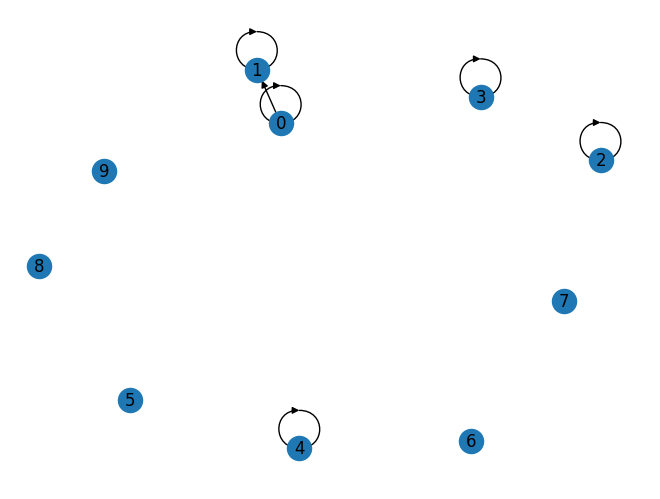

In [290]:
network.vis(detail="point")

In [ ]:
cell = jx.read_swc(f"../../jaxley_experiments/nex/rgc/morphologies/{cell_id}.swc", nseg=4, max_branch_len=300.0, min_radius=5.0)
cell.compute_xyz()
cell._update_nodes_with_xyz()
cell.nodes

In [ ]:
# comp = jx.Compartment()
# comp.compute_xyz()
# comp.update_nodes_with_xyz()

# print(comp.nodes[["x", "y", "z"]])
# print(comp.xyzr)

# cell = jx.read_swc(f"../../jaxley_experiments/nex/rgc/morphologies/{cell_id}.swc", nseg=4, max_branch_len=300.0, min_radius=5.0)

# misc ideas and Qs:
- merge `syn_edges` and `branch_edges` -> edges and replace branch_edge by "type=branch" label, why does base have `edges` and comp has `syn_edges` and `branch_edges`?
- connect should only have to update list of edges!
- what is the reasoning of having comp be a float. I find this counterintuitive since it's discrete. If only important for plotting, then we should only have this in plotting too.

In [ ]:
comp = jx.Compartment()
branch = jx.Branch([comp for _ in range(4)])
cell = jx.Cell([branch for _ in range(5)], parents=jnp.asarray([-1, 0, 0, 1, 1]))
network = jx.Network([cell for _ in range(5)])

network.cell(0).connect(network.cell(1), GlutamateSynapse)
network.cell(1).connect(network.cell(2), GlutamateSynapse)


In [ ]:
type(GlutamateSynapse())

In [ ]:
network.cell(0)

In [ ]:
network.edges

In [ ]:
# "20170610_1" is a t-off-mini
# "20161028_1" is a t-off-alpha
cell_id = "20161028_1"

if cell_id == "20161028_1":
    soma_branch = 1
    dendrite_branch = 50
elif cell_id == "20170610_1":
    soma_branch = 0
    dendrite_branch = 70
else:
    raise ValueError


cell = jx.read_swc(f"../../jaxley_experiments/nex/rgc/morphologies/{cell_id}.swc", nseg=4, max_branch_len=300.0, min_radius=5.0)

cell.insert(HH())
cell.insert(KA())
cell.insert(Ca())
cell.insert(KCa())

cell.set("v", -65.0)
cell.init_states()

cell.delete_trainables()

cell.delete_stimuli()
cell.delete_recordings()

cell.branch(soma_branch).loc(0.4).stimulate(current)
cell.branch(soma_branch).loc(0.4).record()
cell.branch(dendrite_branch).loc(1.0).record()

In [ ]:
dims=[0,1]
soma = cell.xyzr[1][0]
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
dmin, dmax = 0, 182
for i in np.unique(cell.show()["branch_index"]):
    xyzr = cell.xyzr[i]
    d = np.sqrt(np.sum((xyzr[:, dims] - soma[dims])**2, axis=1)).mean()
    c = np.array(plt.cm.viridis((d-dmin)/(dmax-dmin)))
    cell.branch(i).vis(col=c, ax=ax, dims=dims)
plt.show()

In [ ]:
cell.branch(dendrite_branch).show()

In [188]:
# global_post_indices = post_cell_view.view.groupby("cell_index").sample(num_pre, replace=True).index.to_numpy()        
# global_post_indices = global_post_indices.reshape((-1, num_pre), order="F").ravel()

274 ms ± 5.06 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
cell = jx.read_swc(f"../../jaxley_experiments/nex/rgc/morphologies/{cell_id}.swc", nseg=4, max_branch_len=300.0, min_radius=5.0)
cell.compute_xyz()
cell._update_nodes_with_xyz()
cell.nodes

In [ ]:
# comp = jx.Compartment()
# comp.compute_xyz()
# comp.update_nodes_with_xyz()

# print(comp.nodes[["x", "y", "z"]])
# print(comp.xyzr)

# cell = jx.read_swc(f"../../jaxley_experiments/nex/rgc/morphologies/{cell_id}.swc", nseg=4, max_branch_len=300.0, min_radius=5.0)

# misc ideas and Qs:
- merge `syn_edges` and `branch_edges` -> edges and replace branch_edge by "type=branch" label, why does base have `edges` and comp has `syn_edges` and `branch_edges`?
- connect should only have to update list of edges!
- what is the reasoning of having comp be a float. I find this counterintuitive since it's discrete. If only important for plotting, then we should only have this in plotting too.

In [ ]:
comp = jx.Compartment()
branch = jx.Branch([comp for _ in range(4)])
cell = jx.Cell([branch for _ in range(5)], parents=jnp.asarray([-1, 0, 0, 1, 1]))
network = jx.Network([cell for _ in range(5)])

network.cell(0).connect(network.cell(1), GlutamateSynapse)
network.cell(1).connect(network.cell(2), GlutamateSynapse)


In [ ]:
type(GlutamateSynapse())

In [ ]:
network.cell(0)

In [ ]:
network.edges

In [ ]:
# "20170610_1" is a t-off-mini
# "20161028_1" is a t-off-alpha
cell_id = "20161028_1"

if cell_id == "20161028_1":
    soma_branch = 1
    dendrite_branch = 50
elif cell_id == "20170610_1":
    soma_branch = 0
    dendrite_branch = 70
else:
    raise ValueError


cell = jx.read_swc(f"../../jaxley_experiments/nex/rgc/morphologies/{cell_id}.swc", nseg=4, max_branch_len=300.0, min_radius=5.0)

cell.insert(HH())
cell.insert(KA())
cell.insert(Ca())
cell.insert(KCa())

cell.set("v", -65.0)
cell.init_states()

cell.delete_trainables()

cell.delete_stimuli()
cell.delete_recordings()

cell.branch(soma_branch).loc(0.4).stimulate(current)
cell.branch(soma_branch).loc(0.4).record()
cell.branch(dendrite_branch).loc(1.0).record()

In [ ]:
dims=[0,1]
soma = cell.xyzr[1][0]
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
dmin, dmax = 0, 182
for i in np.unique(cell.show()["branch_index"]):
    xyzr = cell.xyzr[i]
    d = np.sqrt(np.sum((xyzr[:, dims] - soma[dims])**2, axis=1)).mean()
    c = np.array(plt.cm.viridis((d-dmin)/(dmax-dmin)))
    cell.branch(i).vis(col=c, ax=ax, dims=dims)
plt.show()

In [ ]:
cell.branch(dendrite_branch).show()